In [79]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import pickle
import os
import statsmodels.api as sm

# Main modules
import PredictionVF as pr
import aws_utils as au

In [37]:
REGION = 'us-east-1'
BUCKET_NAME = 'modelo-pd-2' # Unique through all accounts
FOLDER = 'modelos' # Should be clean before the execution

In [38]:
loan_data = pd.read_csv('hmeq.csv',sep=",")
loan_data.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


In [39]:
na_values = loan_data.isnull().mean()
na_values[na_values>0.7]

Series([], dtype: float64)

In [40]:
# split data into 80/20 while keeping the distribution of bad loans in test set same as that in the pre-split dataset
X = loan_data.drop('BAD', axis = 1)
y = loan_data['BAD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

# specifically hard copying the training sets to avoid Pandas' SetttingWithCopyWarning when we play around with this data later on.
# as noted [here](https://github.com/scikit-learn/scikit-learn/issues/8723), this is currently an open issue between Pandas and Scikit-Learn teams
X_train, X_test = X_train.copy(), X_test.copy()

In [41]:
# first divide training data into categorical and numerical subsets
X_train_cat = X_train.select_dtypes(include = 'object').copy()
X_train_num = X_train.select_dtypes(include = 'number').copy()

In [42]:
# define an empty dictionary to store chi-squared test results
chi2_check = {}

# loop over each column in the training set to calculate chi-statistic with the target variable
for column in X_train_cat:
    chi, p, dof, ex = chi2_contingency(pd.crosstab(y_train, X_train_cat[column]))
    chi2_check.setdefault('Feature',[]).append(column)
    chi2_check.setdefault('p-value',[]).append(round(p, 10))

# convert the dictionary to a DF
chi2_result = pd.DataFrame(data = chi2_check)
chi2_result.sort_values(by = ['p-value'], ascending = True, ignore_index = True, inplace = True)
chi2_result

,Feature,p-value
0,JOB,0.000000
1,REASON,0.010842


In [43]:
# since f_class_if does not accept missing values, we will do a very crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)
# Calculate F Statistic and corresponding p values
F_statistic, p_values = f_classif(X_train_num, y_train)
# convert to a DF
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': F_statistic, 'p values': p_values.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,DELINQ,631.404164,0.000000e+00
1,DEROG,359.231052,0.000000e+00
2,CLAGE,141.886503,0.000000e+00
3,NINQ,126.826527,0.000000e+00
4,DEBTINC,65.672341,0.000000e+00
5,LOAN,35.883642,2.200000e-09
6,MORTDUE,21.755292,3.182100e-06
7,YOJ,11.947109,5.521026e-04
8,VALUE,11.288122,7.861741e-04
9,CLNO,0.028752,8.653596e-01


Text(0.5, 1.0, 'Pearson correlation')

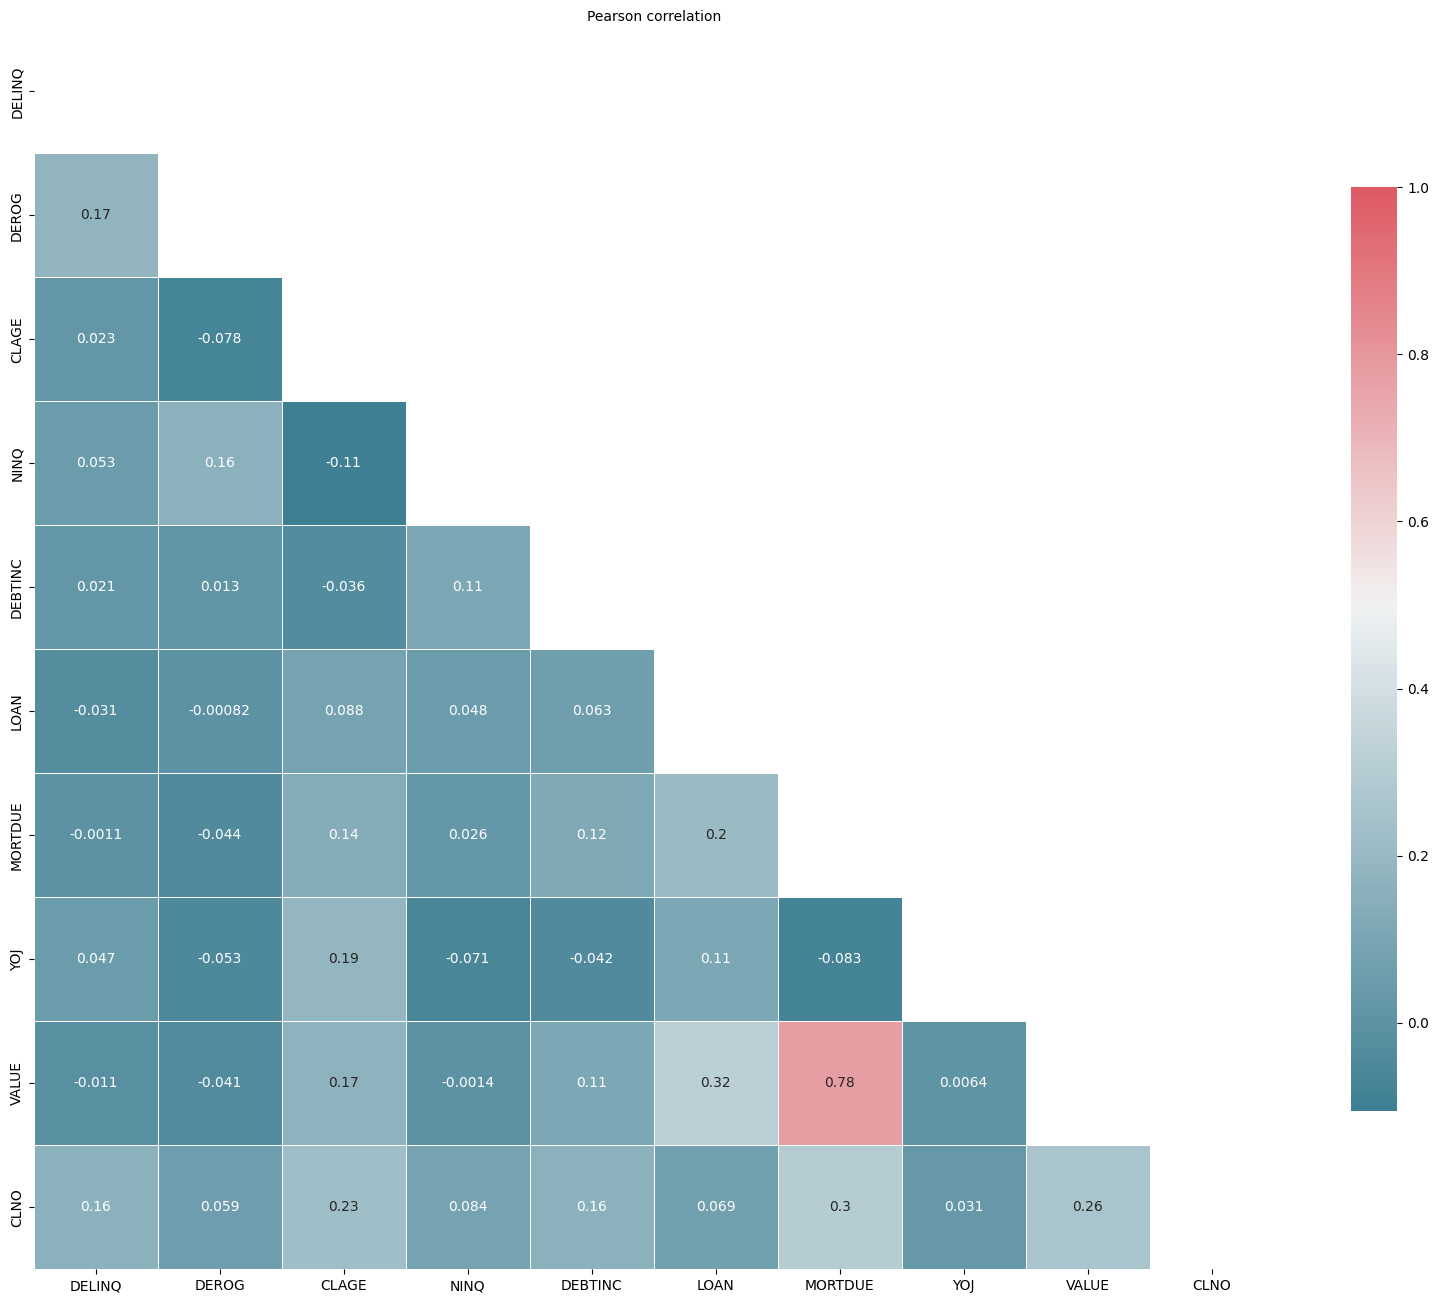

In [44]:
# save the top 20 numerical features in a list
top_num_features = ANOVA_F_table.iloc[:33,0].to_list()
# calculate pair-wise correlations between them
corrmat = X_train_num[top_num_features].corr()
mask = np.triu(np.ones_like(corrmat, dtype=np.bool_))
f, ax = plt.subplots(figsize=(20,20))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(corrmat, cmap= cmap, mask= mask, vmax=1, center=0.5,
            square=True, linewidths=.5, cbar_kws={"shrink": .6},annot=True)

plt.title("Pearson correlation", fontsize =10)

In [45]:
# function to create dummy variables
def dummy_creation(df, columns_list):
    df_dummies = []
    for col in columns_list:
        df_dummies.append(pd.get_dummies(df[col], prefix = col, prefix_sep = ':'))
    df_dummies = pd.concat(df_dummies, axis = 1)
    df = pd.concat([df, df_dummies], axis = 1)
    return df

In [46]:
# apply to our final four categorical variables
X_train = dummy_creation(X_train, ['REASON', 'JOB'])#'verification_status',

In [47]:
X_test = dummy_creation(X_test, ['REASON', 'JOB'])

In [48]:
def fill_null_with_zeros(dataframe, columns_to_fill):
    """
    Completa los valores nulos con ceros en las columnas especificadas de un DataFrame.

    Parámetros:
    dataframe (pd.DataFrame): El DataFrame que se va a modificar.
    columns_to_fill (list): Una lista de nombres de columnas en las que se deben llenar los valores nulos con ceros.

    Retorna:
    pd.DataFrame: El DataFrame modificado.
    """
    for column in columns_to_fill:
        dataframe[column].fillna(0, inplace=True)
    return dataframe

In [49]:
columns_to_fill_with_zeros = ['DEROG', 'DEBTINC','DELINQ','NINQ','CLNO','MORTDUE','YOJ','CLAGE']

In [50]:
X_train=fill_null_with_zeros(X_train, columns_to_fill_with_zeros)

In [51]:
X_test=fill_null_with_zeros(X_test, columns_to_fill_with_zeros)

In [52]:
def fill_null_with_mean(dataframe, columns_to_fill):
    """
    Completa los valores nulos en las columnas especificadas con la media de esa columna.

    Parámetros:
    dataframe (pd.DataFrame): El DataFrame que se va a modificar.
    columns_to_fill (list): Una lista de nombres de columnas en las que se deben llenar los valores nulos con la media.

    Retorna:
    pd.DataFrame: El DataFrame modificado.
    """
    for column in columns_to_fill:
        mean = dataframe[column].mean()
        dataframe[column].fillna(mean, inplace=True)
    return dataframe

In [53]:
columns_to_fill_with_mean = ['LOAN', 'VALUE']
X_train = fill_null_with_mean(X_train, columns_to_fill_with_mean)

In [54]:
X_test = fill_null_with_mean(X_test, columns_to_fill_with_mean)

In [55]:
columns_to_standardize = ['LOAN',  'VALUE','CLAGE']#'MORTDUE'

# Crea un objeto StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Aplica la estandarización a las columnas seleccionadas
X_train[columns_to_standardize] = scaler.fit_transform(X_train[columns_to_standardize])

In [56]:
# Guardar el objeto StandardScaler en un archivo
#import pickle
#joblib.dump(scaler, 'scaler_model.pkl')

In [57]:
import pickle
import os
# Nombre del archivo
file_name = 'scaler_model.pkl'

# Carpeta de destino
folder_name = 'modelos'

# Combinar la carpeta de destino con el nombre del archivo
file_path = os.path.join(folder_name, file_name)

# Asegurarse de que la carpeta exista
#os.makedirs(folder_name, exist_ok=True)

# Guardar el modelo en un archivo pickle en la carpeta especificada
with open(file_path, 'wb') as file:
    pickle.dump(scaler, file)

In [58]:
columns_to_standardize

['LOAN', 'VALUE', 'CLAGE']

In [59]:
X_test[columns_to_standardize] = scaler.transform(X_test[columns_to_standardize])

In [60]:
columnas_con_nulos = X_train.columns[X_train.isnull().any()]
# Utiliza el método .drop() para eliminar las columnas con valores nulos
X_train_sin_nulos = X_train.drop(columns=columnas_con_nulos)
X_test_sin_nulos = X_test.drop(columns=columnas_con_nulos)
rows_with_nulls = X_train[columnas_con_nulos].isnull().any(axis=1)
X_train_with_nulls = X_train[rows_with_nulls]

In [61]:
X_train_sin_nulos=X_train_sin_nulos.drop(columns=['MORTDUE','REASON:HomeImp'])

In [62]:
X_test_sin_nulos=X_test_sin_nulos.drop(columns=['MORTDUE','REASON:HomeImp'])

In [63]:
# Crear un modelo de regresión logística
model = LogisticRegression()

# Entrenar el modelo en los datos de entrenamiento
result=model.fit(X_train_sin_nulos, y_train)

# Realizar predicciones en los datos de prueba
y_pred = result.predict(X_test_sin_nulos)

from sklearn.metrics import accuracy_score, classification_report
# Evaluar el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Precisión del modelo: {accuracy:.2f}')

Precisión del modelo: 0.86


C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
# Imprimir los coeficientes (betas)
coefficients = result.coef_
intercept = result.intercept_

print("Coeficientes (Betas):", coefficients)
print("Intercepto (Beta0):", intercept)

Coeficientes (Betas): [[-9.43267902e-02  1.08146061e-01 -5.63129724e-03  5.36697814e-01
   6.98874582e-01 -5.44363868e-01  1.58074290e-01  7.04979032e-04
  -5.77036238e-02 -2.42534974e-01  6.76996963e-01  2.98494149e-01
   1.04187674e+00  6.09624940e-01  2.26230840e+00  1.32420837e+00]]
Intercepto (Beta0): [-1.51916084]


In [65]:
import pickle
import os

# Nombre del archivo
file_name = 'modelo.pkl'
# Combinar la carpeta de destino con el nombre del archivo
file_path = os.path.join(folder_name, file_name)
# Guardar el modelo en un archivo pickle en la carpeta especificada
with open(file_path, 'wb') as file:
    pickle.dump(result, file)

In [66]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix

# Realizar predicciones con el modelo
y_pred_probs = result.predict(X_test_sin_nulos)

# Convertir probabilidades en etiquetas de clase (puedes ajustar un umbral si es necesario)
y_pred_labels = (y_pred_probs > 0.5).astype(int)

# Calcular ROC AUC
roc_auc = roc_auc_score(y_test, y_pred_probs)

# Calcular precisión
precision = precision_score(y_test, y_pred_labels)

# Calcular recall
recall = recall_score(y_test, y_pred_labels)

# Calcular matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Imprimir resultados
print("ROC AUC:", roc_auc)
print("Precisión:", precision)
print("Recall:", recall)
print("Matriz de Confusión:\n", conf_matrix)

ROC AUC: 0.7116959991543786
Precisión: 0.7676056338028169
Recall: 0.4579831932773109
Matriz de Confusión:
 [[921  33]
 [129 109]]


Testeo predict

In [67]:
import pickle
import os

# Define la ruta a la carpeta donde se encuentran los archivos
folder_path = 'C:/Users/jsrie/Downloads/model-pd-2/modelos'

def fetch_pickle(file_name):
    file_path = os.path.join(folder_path, file_name)
    with open(file_path, 'rb') as f:
        fetched_object = pickle.load(f)
    return fetched_object


In [69]:
###Prueba FINAL:FUNCIONAAAA
#from sklearn.preprocessing import StandardScaler
#import numpy as np

def predict(sample: list) -> dict:
    """
    'sample': List of feature values, including categorical and continuous variables
    """
    model =fetch_pickle('modelo.pkl')# fetch_pickle(BUCKET_NAME, FOLDER, 'modelo.pkl')

    print(f'Received sample: {sample}')
    column_order = ['LOAN', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC', 'REASON:DebtCon', 'JOB:Mgr', 'JOB:Office','JOB:Other', 'JOB:ProfExe', 'JOB:Sales', 'JOB:Self']
    # Organizar 'sample' en el mismo orden que las columnas de entrenamiento
    sample_ordered = [sample[column_order.index(col)] for col in column_order]

    # Define las características a las que deseas aplicar el StandardScaler
    features_to_scale = ['LOAN', 'VALUE', 'CLAGE']

    # Define los índices de las variables categóricas en 'sample'
    categorical_indices = [column_order.index(col) for col in column_order if col not in features_to_scale]
    # Separate the categorical variables from the continuous variables
    categorical_variables = [sample[i] for i in categorical_indices]
    continuous_variables = [sample[i] for i in range(len(sample)) if i not in categorical_indices]

    # Apply scaling to continuous variables using StandardScaler
    scaler =fetch_pickle('scaler_model.pkl')# fetch_pickle(BUCKET_NAME, FOLDER, 'scaler_model.pkl')
    scaled_continuous_variables = scaler.transform([continuous_variables])

    categorical_variables_2d = np.array(categorical_variables).reshape(1, -1)

    # Concatenate the transformed categorical variables with the scaled continuous variables
    input_data = np.concatenate([categorical_variables_2d, scaled_continuous_variables], axis=1)
    # Add a constant term (intercept) to the input data
    #input_data_with_constant = sm.add_constant(input_data)
    
    # Add a constant term (intercept) to the input data manually
    #constant_column = np.ones((input_data.shape[0], 1))
    #input_data_with_constant = np.concatenate([constant_column, input_data], axis=1)
    # Define el nuevo orden de las columnas
    new_order = [ 13, 14, 0, 1, 2, 15, 3, 4, 5, 6, 7,8, 9, 10, 11,12]

    # Reorganiza las columnas en el nuevo orden
    input_data_fin = input_data[:, new_order]
    # Realizar la predicción de regresión logística
    predicted_probabilities = model.predict_proba(input_data_fin)[:, 1]
    # Perform the logistic regression prediction
    #predicted_probabilities = model.predict(input_data_with_constant)

    # Assuming you want to classify based on a probability threshold (e.g., 0.5)
    predicted_class = 1 if predicted_probabilities >= 0.5 else 0

    predicted_result = {
        'sample': sample,
        'predicted_class': predicted_class,
        'predicted_probabilities': predicted_probabilities
    }

    return predicted_result

In [114]:
sample=[10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
# Call the 'predict' function with the 'sample' list
result = predict(sample)

# Print the prediction result
print(result)


Received sample: [10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]


C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


{'sample': [10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0], 'predicted_class': 0, 'predicted_probabilities': array([0.11035269])}


In [123]:
sample=[10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]

pr.predict(sample)

Loading modelo.pkl from local
Received sample: [10700, 64838, 9.0, 0.0, 0.0, 95.039168, 2.0, 34.0, 40.396233444, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0]
Loading scaler_model.pkl from local


C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\ProgramData\anaconda3\envs\python-3.10\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


{'sample': [10700,
  64838,
  9.0,
  0.0,
  0.0,
  95.039168,
  2.0,
  34.0,
  40.396233444,
  0.0,
  0.0,
  0.0,
  1.0,
  0.0,
  0.0,
  0.0],
 'predicted_class': 0,
 'predicted_probabilities': array([0.11035269])}

In [124]:
import requests as req
req.get('http://localhost:5000/pagador?LOAN=5000&VALUE=10000&YOJ=2&DEROG=0&DELINQ=0&CLAGE=30&NINQ=1&CLNO=10&DEBTINC=35&REASON:DebtCon=1&JOB:Mgr=0&JOB:Office=1&JOB:Other=0&JOB:ProfExe=0&JOB:Sales=0&JOB:Self=0')

<Response [200]>